# Data Randomization Analysis for Function Approximation
This notebook demonstrates how data randomization affects the learning of surrogate models.
We use a simple quadratic function f(x) = (x-10)² as our true function and try to approximate
it using a cubic polynomial Ψ(x) = θ₃x³ + θ₂x² + θ₁x + θ₀.

### The key aspects we investigate are:
1. Learning without data randomization (only matching function values)
2. Learning with data randomization (matching function values, derivatives, and promoting smoothness)
3. Comparative analysis of both approaches


Results With Data Randomization:
θ₀ = 100.00
θ₁ = -20.00
θ₂ = 1.00
θ₃ = -0.00

Results Without Data Randomization:
θ₀ = 100.00
θ₁ = -0.00
θ₂ = -0.01
θ₃ = -0.10

Predictions at x=5:
True value: 25.00
With data randomization: 25.00
Without data randomization: 87.40


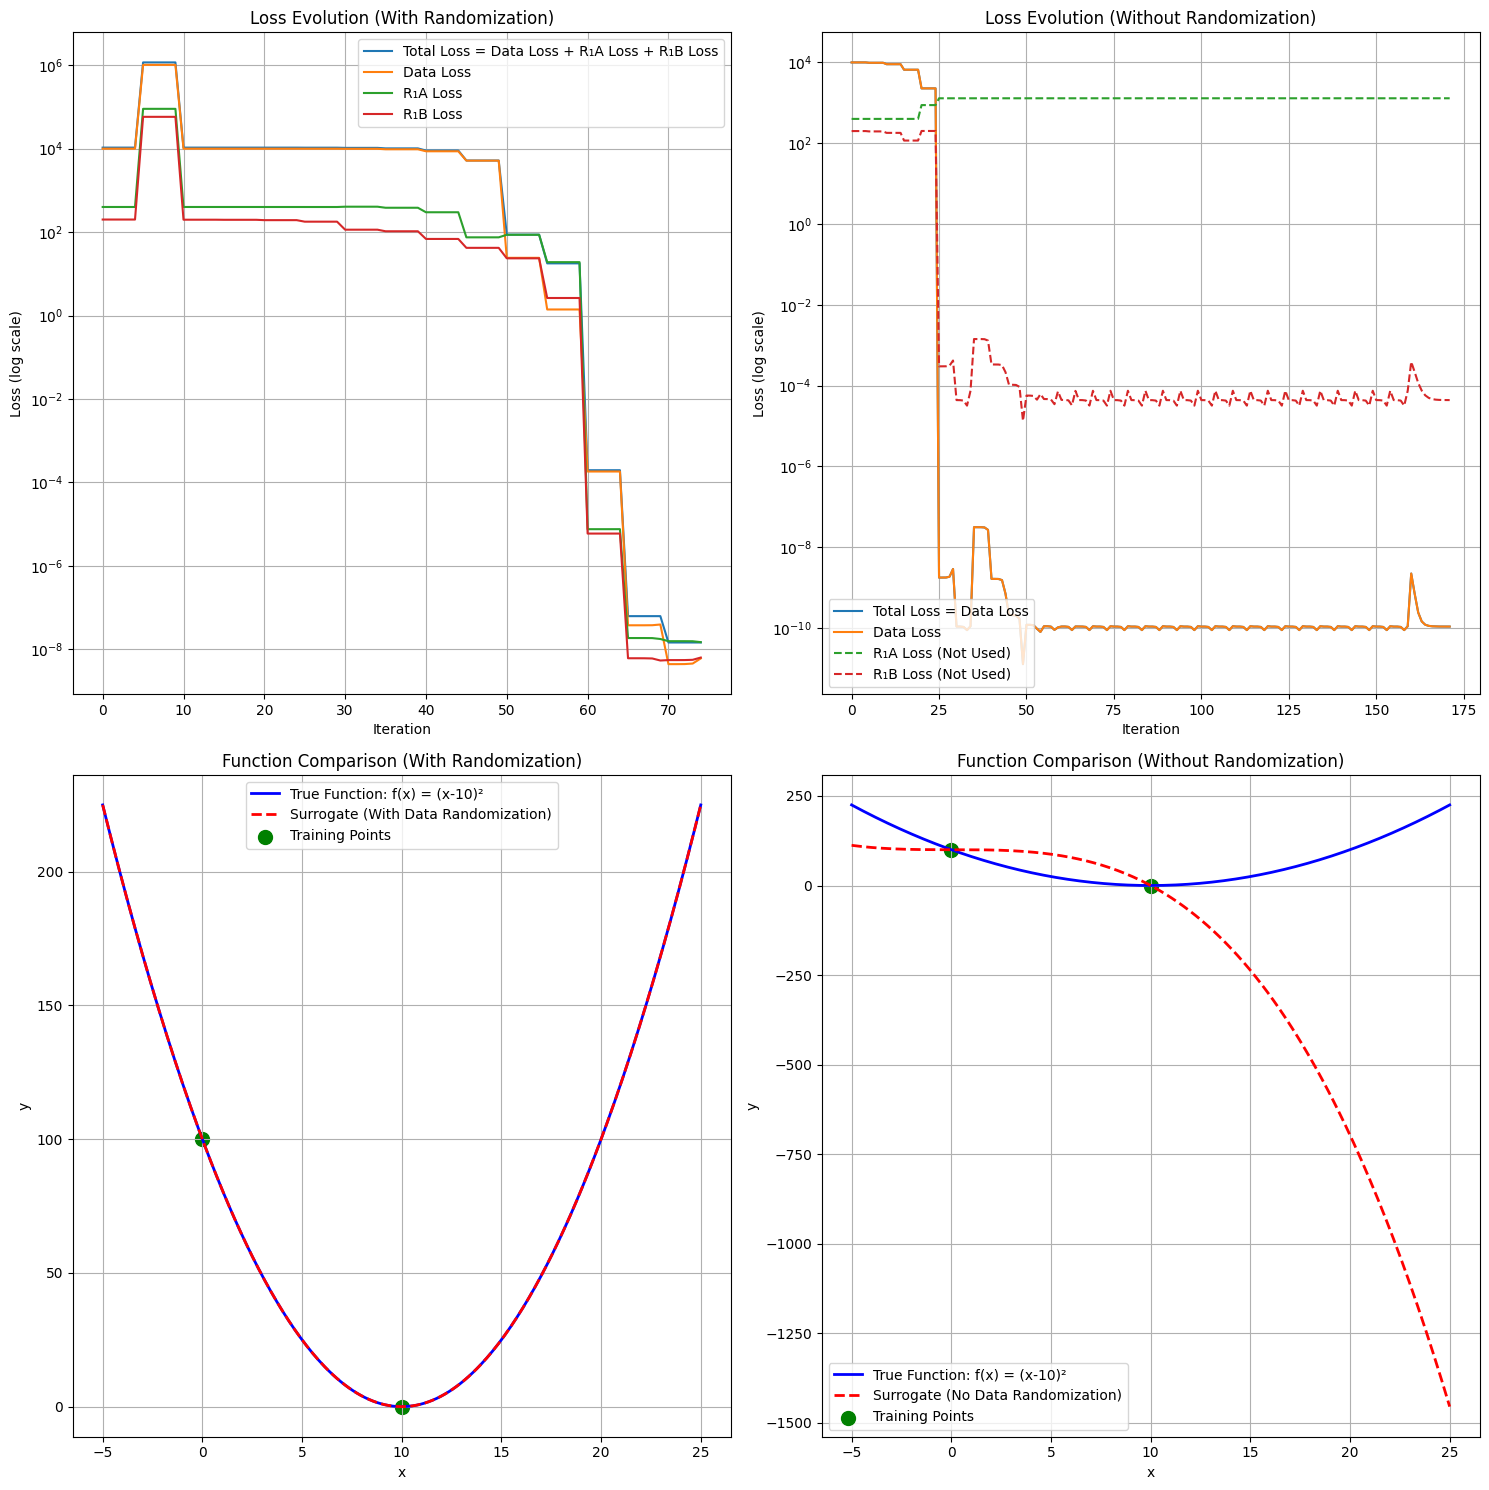

In [30]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class ComparativeOptimization:
    def __init__(self):
        # Create separate loss histories for both approaches
        self.random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
        self.no_random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
        # Create figure with subplots for comparison
        self.fig, ((self.ax1, self.ax2), (self.ax3, self.ax4)) = plt.subplots(2, 2, figsize=(15, 15))
        
    def true_function(self, x):
        """The true function f(x) = (x-10)^2"""
        return (x - 10) ** 2

    def surrogate_model(self, x, theta):
        """Surrogate model Ψ(x) = θ₃x³ + θ₂x² + θ₁x + θ₀"""
        return theta[3] * x**3 + theta[2] * x**2 + theta[1] * x + theta[0]

    def surrogate_derivative(self, x, theta):
        """First derivative of surrogate model"""
        return 3 * theta[3] * x**2 + 2 * theta[2] * x + theta[1]

    def surrogate_second_derivative(self, x, theta):
        """Second derivative of surrogate model"""
        return 6 * theta[3] * x + 2 * theta[2]

    def true_derivative(self, x):
        """First derivative of true function"""
        return 2 * (x - 10)

    def true_second_derivative(self, x):
        """Second derivative of true function"""
        return 2

    def calculate_loss_components(self, theta, include_data_randomization=True):
        """Calculate loss components with option for regularization"""
        x_points = np.array([0, 10])
        
        # Original loss term
        original_loss = 0
        for x in x_points:
            original_loss += (self.true_function(x) - self.surrogate_model(x, theta))**2
        
        # R₁A term (first derivative matching)
        R1A_loss = 0
        for x in x_points:
            R1A_loss += (self.true_derivative(x) - self.surrogate_derivative(x, theta))**2
        
        # R₁B term (second derivative and function difference)
        R1B_loss = 0
        for x in x_points:
            R1B_loss += (self.true_second_derivative(x) - self.surrogate_second_derivative(x, theta)) * \
                        (self.true_function(x) - self.surrogate_model(x, theta))
        
        # Total loss depends on whether we include regularization
        if include_data_randomization:
            total_loss = original_loss + R1A_loss + R1B_loss
        else:
            total_loss = original_loss
        
        return total_loss, original_loss, R1A_loss, R1B_loss

    def loss_function(self, theta, include_data_randomization=True):
        """Unified loss function with regularization flag"""
        total_loss, original_loss, R1A_loss, R1B_loss = self.calculate_loss_components(theta, include_data_randomization)
        
        # Store values in appropriate history
        history = self.random_loss_history if include_data_randomization else self.no_random_loss_history
        history['total_loss'].append(total_loss)
        history['original_loss'].append(original_loss)
        history['R1A_loss'].append(R1A_loss)
        history['R1B_loss'].append(R1B_loss)
        
        return total_loss

    def plot_comparative_results(self, theta_random, theta_no_random):
        """Plot comparative results for both approaches"""
        # Clear all plots
        for ax in [self.ax1, self.ax2, self.ax3, self.ax4]:
            ax.clear()
        
        # Plot 1: Loss History with Randomization
        iterations = range(len(self.random_loss_history['total_loss']))
        self.ax1.semilogy(iterations, self.random_loss_history['total_loss'], label='Total Loss = Data Loss + R₁A Loss + R₁B Loss')
        self.ax1.semilogy(iterations, self.random_loss_history['original_loss'], label='Data Loss')
        self.ax1.semilogy(iterations, np.abs(self.random_loss_history['R1A_loss']), label='R₁A Loss')
        self.ax1.semilogy(iterations, np.abs(self.random_loss_history['R1B_loss']), label='R₁B Loss')
        self.ax1.set_title('Loss Evolution (With Randomization)')
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Loss (log scale)')
        self.ax1.legend()
        self.ax1.grid(True)
        
        # Plot 2: Loss History without Randomization
        iterations = range(len(self.no_random_loss_history['total_loss']))
        self.ax2.semilogy(iterations, self.no_random_loss_history['total_loss'], label='Total Loss = Data Loss') 
        self.ax2.semilogy(iterations, self.no_random_loss_history['original_loss'], label='Data Loss')
        self.ax2.semilogy(iterations, np.abs(self.no_random_loss_history['R1A_loss']), '--', label='R₁A Loss (Not Used)')
        self.ax2.semilogy(iterations, np.abs(self.no_random_loss_history['R1B_loss']), '--', label='R₁B Loss (Not Used)')
        self.ax2.set_title('Loss Evolution (Without Randomization)')
        self.ax2.set_xlabel('Iteration')
        self.ax2.set_ylabel('Loss (log scale)')
        self.ax2.legend()
        self.ax2.grid(True)
        
        # Plot 3 & 4: Function Comparisons
        x_range = np.linspace(-5, 25, 300)
        true_values = [self.true_function(x) for x in x_range]
        surrogate_values_random = [self.surrogate_model(x, theta_random) for x in x_range]
        surrogate_values_no_random = [self.surrogate_model(x, theta_no_random) for x in x_range]
        
        # With Randomization
        self.ax3.plot(x_range, true_values, 'b-', label='True Function: f(x) = (x-10)²', linewidth=2)
        self.ax3.plot(x_range, surrogate_values_random, 'r--', label='Surrogate (With Data Randomization)', linewidth=2)
        x_points = np.array([0, 10])
        y_points = [self.true_function(x) for x in x_points]
        self.ax3.scatter(x_points, y_points, color='green', s=100, label='Training Points')
        self.ax3.set_title('Function Comparison (With Randomization)')
        self.ax3.set_xlabel('x')
        self.ax3.set_ylabel('y')
        self.ax3.legend()
        self.ax3.grid(True)
        
        # Without Randomization
        self.ax4.plot(x_range, true_values, 'b-', label='True Function: f(x) = (x-10)²', linewidth=2)
        self.ax4.plot(x_range, surrogate_values_no_random, 'r--', label='Surrogate (No Data Randomization)', linewidth=2)
        self.ax4.scatter(x_points, y_points, color='green', s=100, label='Training Points')
        self.ax4.set_title('Function Comparison (Without Randomization)')
        self.ax4.set_xlabel('x')
        self.ax4.set_ylabel('y')
        self.ax4.legend()
        self.ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

    def run_comparative_analysis(self):
        """Run optimization with and without randomization and compare results"""
        # Clear previous histories
        for history in [self.random_loss_history, self.no_random_loss_history]:
            for key in history:
                history[key] = []
        
        # Initial guess for both approaches
        theta_init = np.zeros(4)
        
        # Optimize with randomization
        result_random = minimize(lambda theta: self.loss_function(theta, True), 
                               theta_init, method='BFGS', options={'maxiter': 10})
        theta_random = result_random.x
        
        # Optimize without randomization
        result_no_random = minimize(lambda theta: self.loss_function(theta, False), 
                                  theta_init, method='BFGS', options={'maxiter': 10})
        theta_no_random = result_no_random.x
        
        # Print comparative results
        print("\nResults With Data Randomization:")
        print(f"θ₀ = {theta_random[0]:.2f}")
        print(f"θ₁ = {theta_random[1]:.2f}")
        print(f"θ₂ = {theta_random[2]:.2f}")
        print(f"θ₃ = {theta_random[3]:.2f}")
        
        print("\nResults Without Data Randomization:")
        print(f"θ₀ = {theta_no_random[0]:.2f}")
        print(f"θ₁ = {theta_no_random[1]:.2f}")
        print(f"θ₂ = {theta_no_random[2]:.2f}")
        print(f"θ₃ = {theta_no_random[3]:.2f}")
        
        # Test predictions at unseen point
        x_test = 5
        true_value = self.true_function(x_test)
        pred_random = self.surrogate_model(x_test, theta_random)
        pred_no_random = self.surrogate_model(x_test, theta_no_random)
        
        print(f"\nPredictions at x=5:")
        print(f"True value: {true_value:.2f}")
        print(f"With data randomization: {pred_random:.2f}")
        print(f"Without data randomization: {pred_no_random:.2f}")
        
        # Plot comparative results
        self.plot_comparative_results(theta_random, theta_no_random)
        
        return theta_random, theta_no_random

if __name__ == "__main__":
    optimizer = ComparativeOptimization()
    theta_random, theta_no_random = optimizer.run_comparative_analysis()